# 線形判別分析（LDA)

LDAはクラスの分離を最適化する特徴部分空間を見つける手法<br>
教師ありアルゴリズムのため、分類タスクの特徴抽出の手段としてはPCAより優れている<br>
この手法を行う前提として、
* データが正規分布に従っている
* クラスの共分散行列が全く同じであること
* 特徴量が互いに独立していること

が挙げられる<br>
ただし、多少満たしていなくても、次元削減の手段としてはそれなりにうまく行くらしい<br>
以下にアルゴリズムの流れを記載する

#### 1. データセットを標準化する

In [1]:
# データ読み込み
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

# データをトレーニング用とテスト用に7:3に分割
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# 2列目以降をXに、1列目をyに格納
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
# データをトレーニング用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# 平均と標準偏差で標準化
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

#### 2. クラスごとの平均ベクトルを計算する

クラスiの平均ベクトル$m_i$は以下の式で表される
$$
{\bf m_i} = \frac{1}{n_i}\sum_{{\bf x} \in D_i}{\bf x}
$$
※ $n_i$はクラスiのサンプル数、$D_i$はクラスiの特徴量全体を表す。$m_i$にはi毎の各次元(m)の平均$\mu_m$が格納される

$$
{\bf m_i} = 
\left [
  \begin{array}{c}
    \mu_{i,alcohol} \\
    \mu_{i,malic acid} \\
    \vdots \\
    \mu_{i,proline} \\
  \end{array}
\right]^T
i \in \{1, 2, 3\}
$$

In [2]:
import numpy as np
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('mean value %s: %s\n' % (label, mean_vecs[label-1]))

mean value 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

mean value 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

mean value 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



#### 3. クラス間変動行列${\bf S}_B$とクラス内変動行列${\bf S}_W$を生成する

クラス内変動行列は、個々のクラスについての変動行列の合計である（変動行列は共分散行列の正規化していないバージョン）
$$
{\bf S}_w = \sum_{i=1}^c{\bf S}_i
$$
個々のクラスの変動行列を表す式は以下
$$
S_i = \sum_{x \in {\bf D}_i}({\bf x} - {\bf m_i})({\bf x} - {\bf m_i})^T
$$

In [3]:
# 実際に変動行列を計算する
d = 13 # 特徴量の個数
S_W = np.zeros((d, d)) # クラス内変動行列
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d)) # クラスの変動行列
    for row in X_train_std[y_train==label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


変動行列を計算する際はクラスラベルが一様に分布していることが前提になるが、以下の通り一様ではない

In [4]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


このため、各クラスごとの変動行列をサンプルの個数$N_i$で割り、スケーリングするが、これは共分散行列の計算と同じ<br>
そのため、上記の変動行列の計算は以下のように置き換えられる

In [5]:
d = 13 # 特徴量の個数
S_W = np.zeros((d, d)) # クラス内変動行列
for label in zip(range(1, 4)):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
    
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


クラス間変動行列$S_B$は、すべてのクラスのサンプルを対象として計算される全体平均${\bf m}$を用いて以下のように表す
$$
{\bf S}_B = \sum_{i=1}^c N_i({\bf m}_i - {\bf m})({\bf m}_i - {\bf m})^T
$$

In [6]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13 # 次元数
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train==i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
    
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


#### 4. 行列${\bf S}_W^{-1}{\bf S}_B$の固有ベクトル、固有値を算出する

In [7]:
# inv - 逆行列
# dot - 行列積
# eig - 固有値計算
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
# 固有値の降順で並べ替える
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigen values in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigen values in decreasing order:

452.721581245
156.43636122
4.78698572234e-14
4.78698572234e-14
2.84217094304e-14
2.24574593261e-14
2.24574593261e-14
2.05218581651e-14
2.05218581651e-14
7.60661108973e-15
7.60661108973e-15
5.29948576842e-15
3.43141976276e-15


クラス間変動行列${\bf S}_B$は、階数（独立な列数）が1以下のクラスの数ぶん合計したものである（証明は略）<br>
このため、クラスラベルの個数をcとした場合、LDAでの線形判別の個数は最大でc-1個となる（c個の独立なベクトルを次元削減するため）<br>
上記の3〜13番めの固有値はnumpyの浮動小数点の演算により、0になっていないだけ<br>
共線性が完全な場合のみ、階数が1で固有ベクトルも1となる

#### 5. 最も大きいk個の固有値に対応するk個の固有ベクトルを選択し、固有ベクトルを列とした行列$\bf W$を作成する

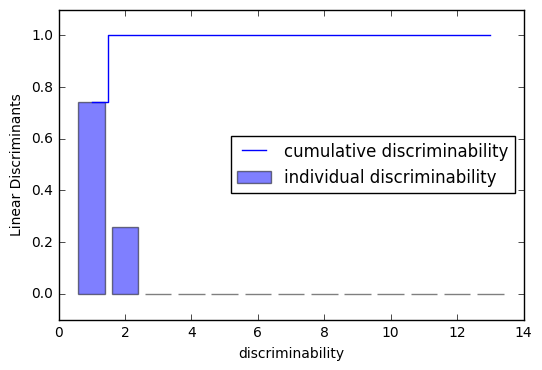

In [8]:
# 判別性を可視化
import matplotlib.pyplot as plt
tot = sum(eigen_vals.real) # 固有値の実数部の総和
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)] # 分散説明率
cum_discr = np.cumsum(discr) # 累積和
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative discriminability')
plt.xlabel('discriminability')
plt.ylabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

In [9]:
# 最初の2つの固有ベクトルを選択し、Wを作成する
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print 'Matrix W: \n', w

Matrix W: 
[[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


#### 6. データにWを掛け、新しい特徴空間にサンプルを射影する

以下のように変換行列を掛け、データを変換する
$$
{\bf X'} = {\bf XW}
$$

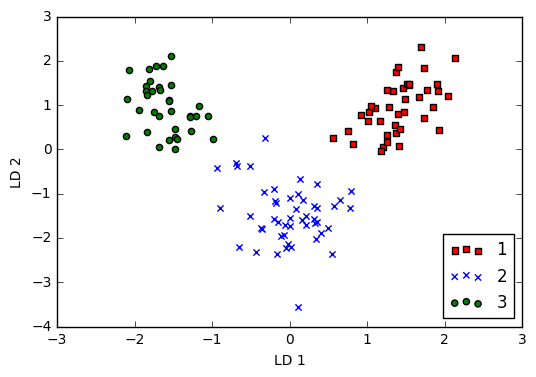

In [10]:
# データを変換する
X_train_lda = X_train_std.dot(w)

# 変換後のデータをプロットし、可視化する
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0] * (-1), X_train_lda[y_train==l, 1] * (-1), c=c, label=l, marker=m)
    
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.show()

### scikit-learnによるLDA

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# 次元数を指定しインスタンスを生成
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02, xlabel='x', ylabel='y', title='title', legend_loc='upper left'):
    
    # マーカーとカラーマップの準備
    markers = ('s', 'o', 'v', '^', 'x')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, aplha=0.4, cmap=cmap)
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
        # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)
        
    # テストサンプルを目立たせる
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='',
                   alpha=1.0, linewidths=1, marker='o',
                   s=55, label='test set')
        
    # 軸のラベルの設定
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # タイトル設定
    plt.title(title)
    # 凡例の設定
    plt.legend(loc=legend_loc)
    # 図の表示
    plt.show()

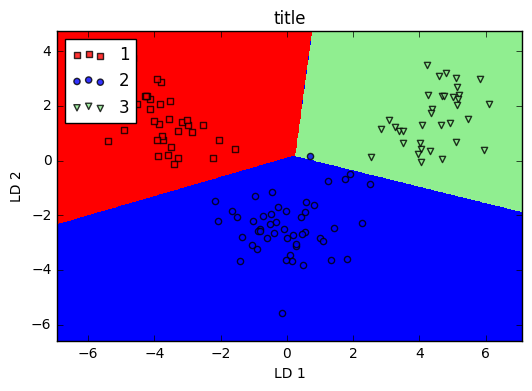

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr, xlabel='LD 1', ylabel='LD 2')

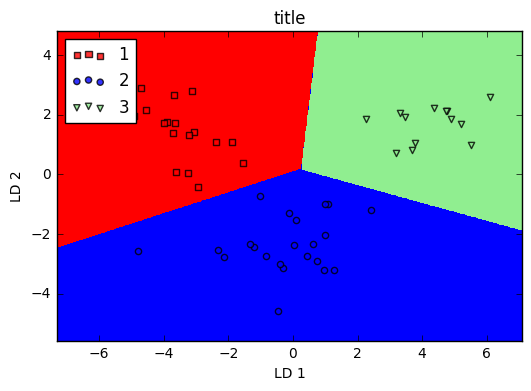

In [14]:
# テストデータでも同様に確認
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr, xlabel='LD 1', ylabel='LD 2')